# Basic Time Series Analysis & Feature Selection

sentences starting with a dot (as below) is my personal opinion. 

* have fun!`enter code here`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import xgboost as xgb
from sklearn import model_selection, preprocessing
color = sns.color_palette()
%matplotlib inline
# result transform
def num2log(arr):
    return np.log(arr + 1)
# result retransform
def log2num(arr):
    return np.exp(arr) - 1
# treat date
def trans_date(arr): 
    return datetime.datetime.strptime(arr, '%Y-%m-%d').date()

## Input data & have a quick look

In [2]:
train_df = pd.read_csv('../input/train.csv')
print('In trainset, there are {} rows and {} columns'.format(train_df.shape[0],train_df.shape[1]))
train_df.head()

In trainset, there are 30471 rows and 292 columns


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [3]:
print('check if id is unique: ' + str(len(pd.unique(train_df.id)) == train_df.shape[0]))

check if id is unique: True


### have a look at the distribution of log price

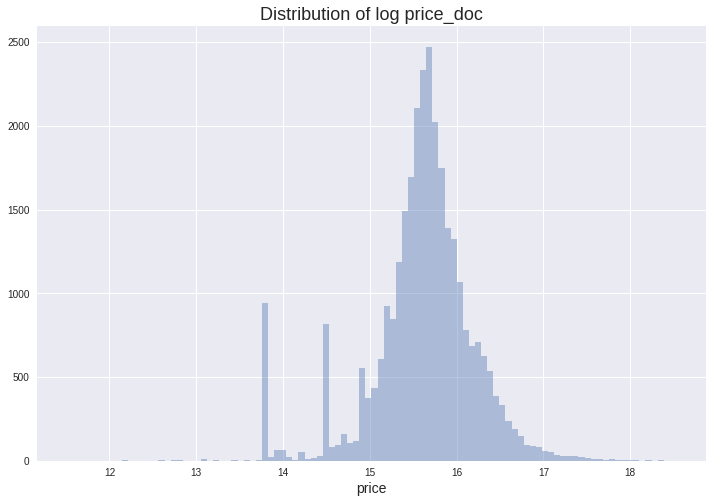

In [4]:
plt.figure(figsize=(12,8))
sns.distplot(num2log(train_df.price_doc.values), bins=100, kde=False)
plt.xlabel('price', fontsize=14)
plt.title('Distribution of log price_doc', fontsize = 18)
plt.show()

* not bad

## Time Analysis
derive column `month#` and `month` to see the trend and periodic charateristics

In [5]:
train_df['date'] = train_df['timestamp'].apply(trans_date)
train_df['year'] = train_df.date.apply(lambda x: x.year)
train_df['month_num'] = train_df.date.apply(lambda x: x.month + 12*(x.year-2011))
train_df['month'] = train_df.date.apply(lambda x: x.month)
start_date = train_df.date.min()
train_df['diff_date'] = train_df['date'].apply(lambda x: (x - start_date).days)
train_df['log_price'] = num2log(train_df.price_doc.values)

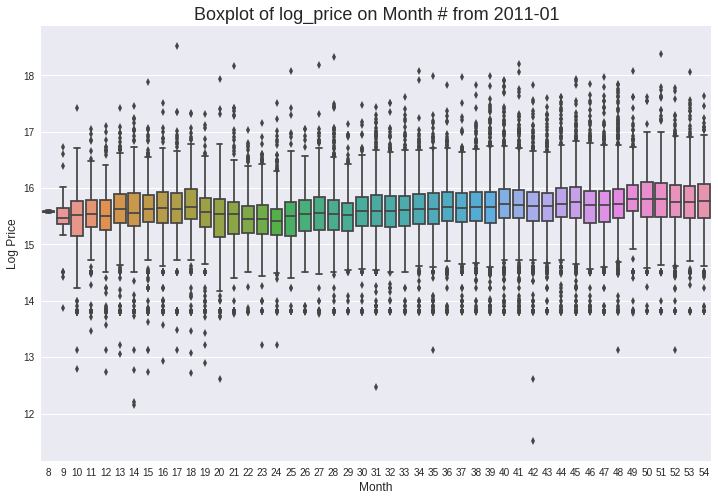

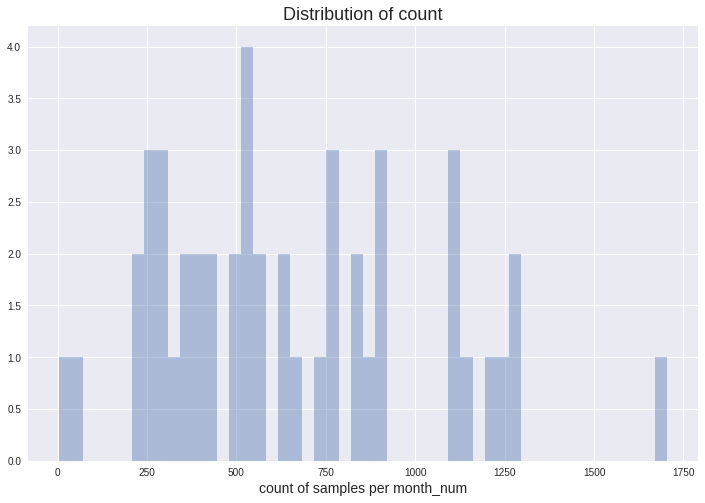

In [6]:
month_num_count = train_df.groupby('month_num').count().reset_index()
month_num_count = train_df.groupby('month_num').size().reset_index()
month_num_count.columns = ['month_num', 'Count']
plt.figure(figsize=(12,8))
sns.boxplot(x = 'month_num', y = 'log_price', data = train_df)
plt.ylabel('Log Price', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Boxplot of log_price on Month # from 2011-01', fontsize = 18)
plt.show()
plt.figure(figsize=(12,8))
sns.distplot(month_num_count.Count.values, bins=50, kde=False)
plt.xlabel('count of samples per month_num', fontsize=14)
plt.title('Distribution of count', fontsize = 18)
plt.show()

* there is no obvious increasing or decreasing trend.

the second plot is to show the confidence of the conclusion based on the count of samples.

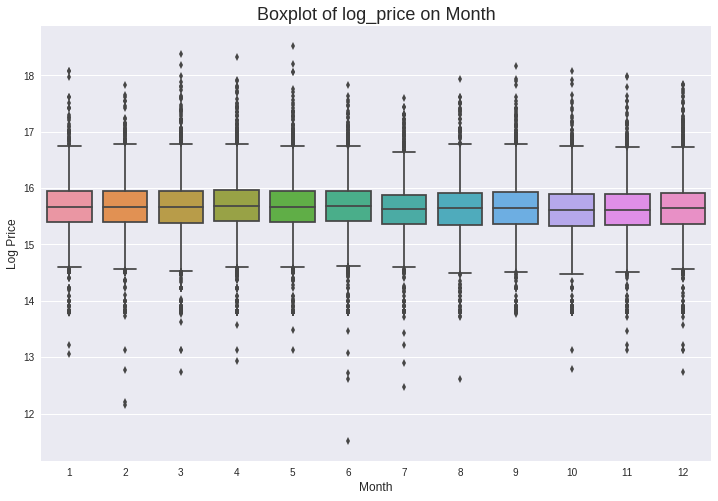

In [7]:
plt.figure(figsize=(12,8))
sns.boxplot(x = 'month', y = 'log_price', data = train_df)
plt.ylabel('Log Price', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Boxplot of log_price on Month', fontsize = 18)
plt.show()

* there is no obvious seasonal periodic characteristics

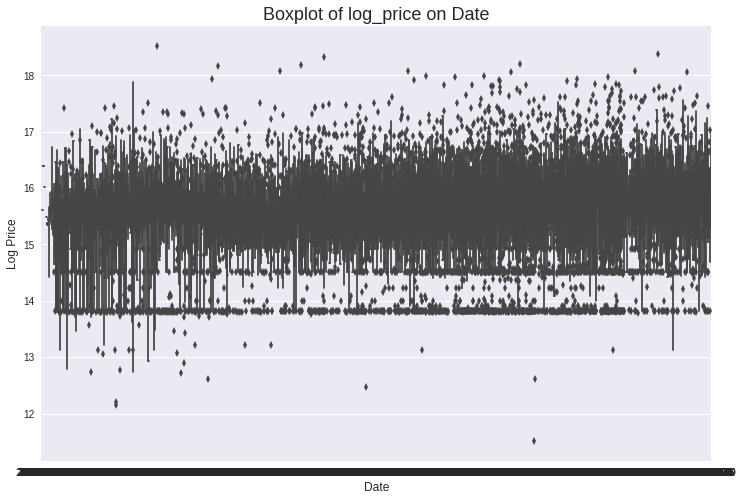

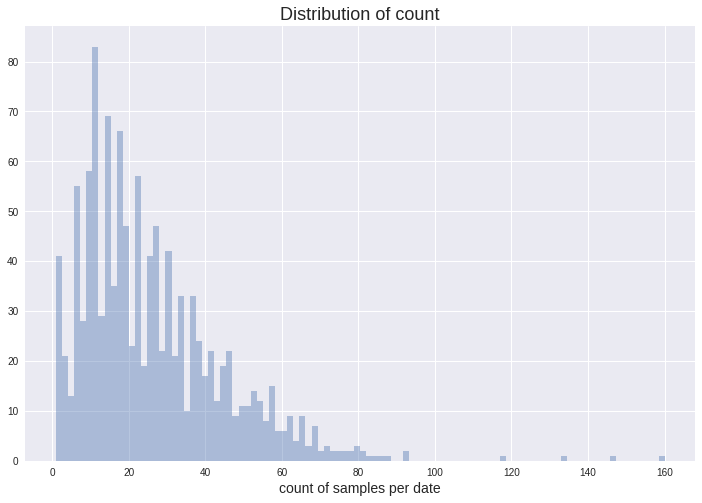

In [8]:
date_count = train_df.groupby('date').count().reset_index()
date_count = train_df.groupby('date').size().reset_index()
date_count.columns = ['date', 'Count']
plt.figure(figsize=(12,8))
sns.boxplot(x = 'date', y = 'log_price', data = train_df)
plt.ylabel('Log Price', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Boxplot of log_price on Date', fontsize = 18)
plt.show()
plt.figure(figsize=(12,8))
sns.distplot(date_count.Count.values, bins=100, kde=False)
plt.xlabel('count of samples per date', fontsize=14)
plt.title('Distribution of count', fontsize = 18)
plt.show()

I will not make any conclusion due to the low counts for most dates

## Missing values

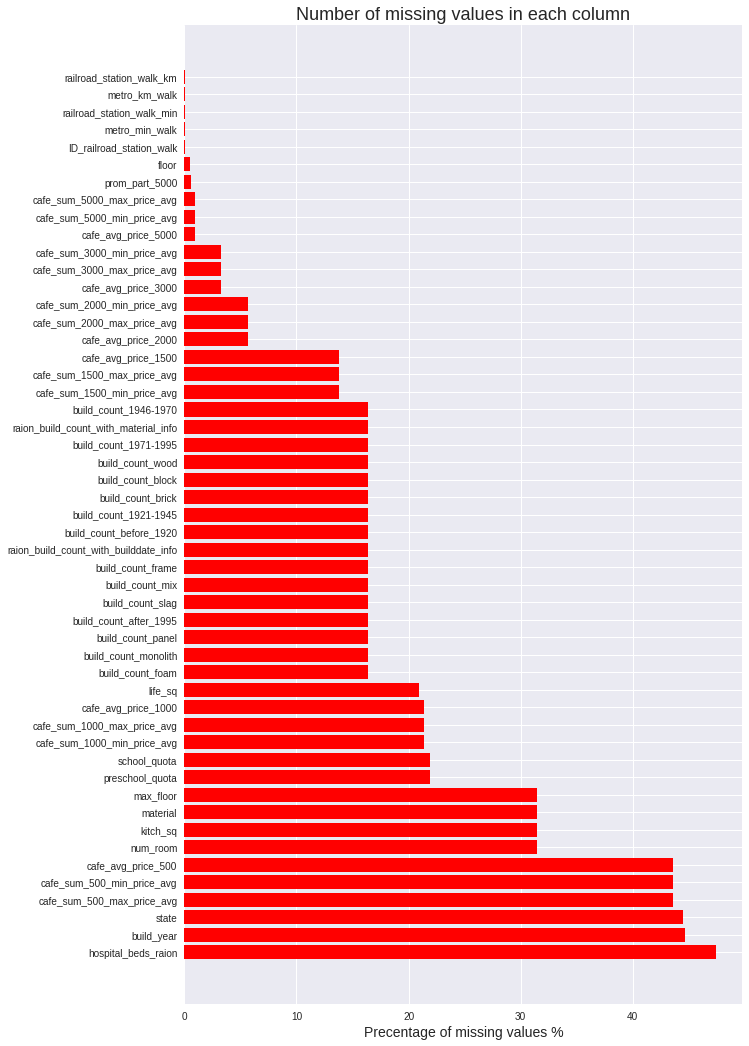

In [9]:
missing = train_df.isnull().sum(0).reset_index()
missing.columns = ['column', 'count']
missing = missing.sort_values(by = 'count', ascending = False).loc[missing['count'] > 0]
missing['percentage'] = missing['count'] / float(train_df.shape[0]) * 100
ind = np.arange(missing.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, missing.percentage.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(missing.column.values, rotation='horizontal')
ax.set_xlabel("Precentage of missing values %", fontsize = 14)
ax.set_title("Number of missing values in each column", fontsize = 18)
plt.show()

* delete columns with more than 20% missing

In [10]:
delete_col = missing.loc[missing['percentage'] >= 20].column.values
train_set = train_df.drop(delete_col, axis=1)

## Feature selection by correlation

In [11]:
for f in train_set.columns:
    if train_set[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_set[f].values)) 
        train_set[f] = lbl.transform(list(train_set[f].values))
dtype_df = train_set.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,178
1,float64,104


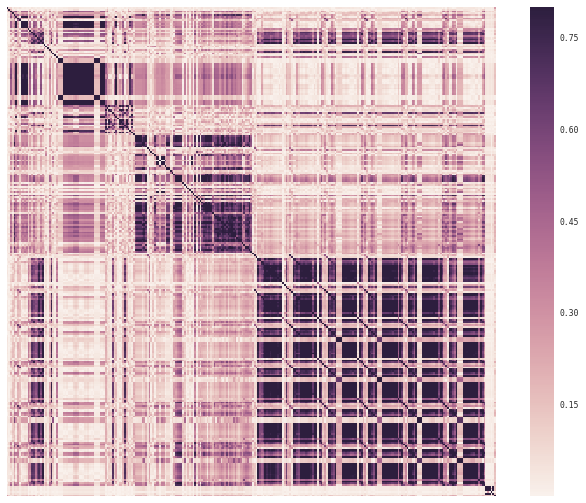

In [12]:
corrmat = train_set.drop(["id", "timestamp", "price_doc"], axis=1).corr(method='pearson', min_periods=1000)
# plot absolute values
corrmat = np.abs(corrmat)
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, xticklabels = False, yticklabels = False)

* OMG, how beautiful is it!!
* Calm down!
* It shows that there are many features has high correlations, maybe we can reduce them.

### Correlation between target and log_price

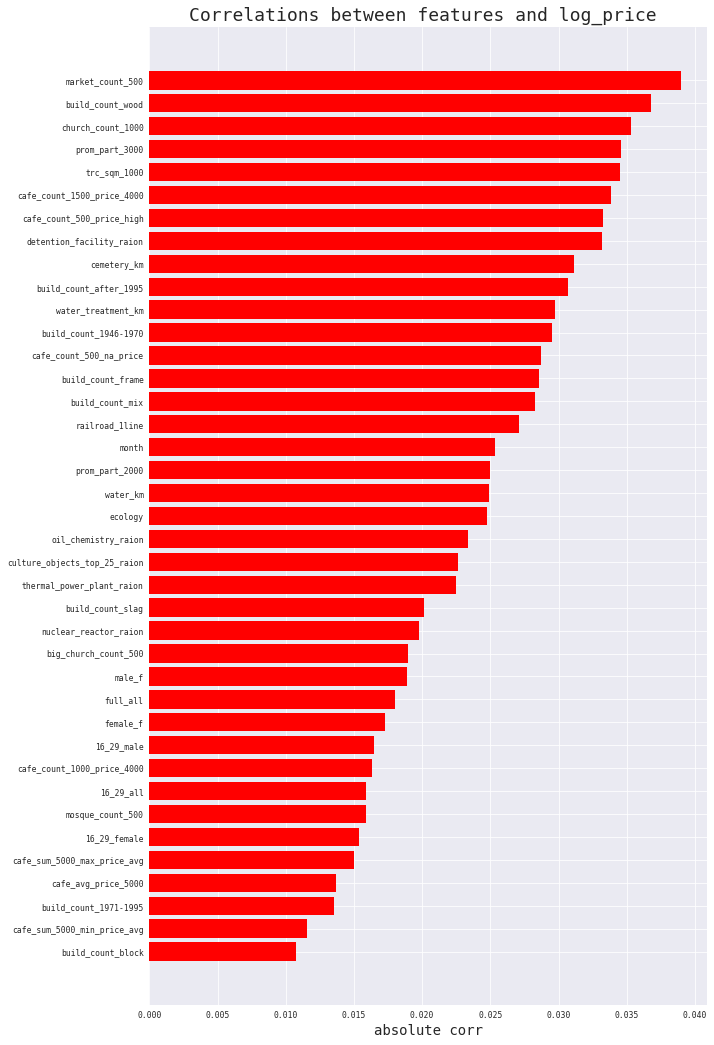

In [13]:
remain_num = 50
corr_target = corrmat['log_price'].reset_index()[:-2]
corr_target.columns = ['feature','abs_corr']
corr_target = corr_target.sort_values(by = 'abs_corr', ascending = True)[:remain_num].loc[corr_target['abs_corr'] >0.01]
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, corr_target.abs_corr.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 14)
ax.set_title("Correlations between features and log_price ", fontsize = 18)
plt.show()

In [14]:
corr_target_f = list(corr_target.feature.values)

### correlation between features

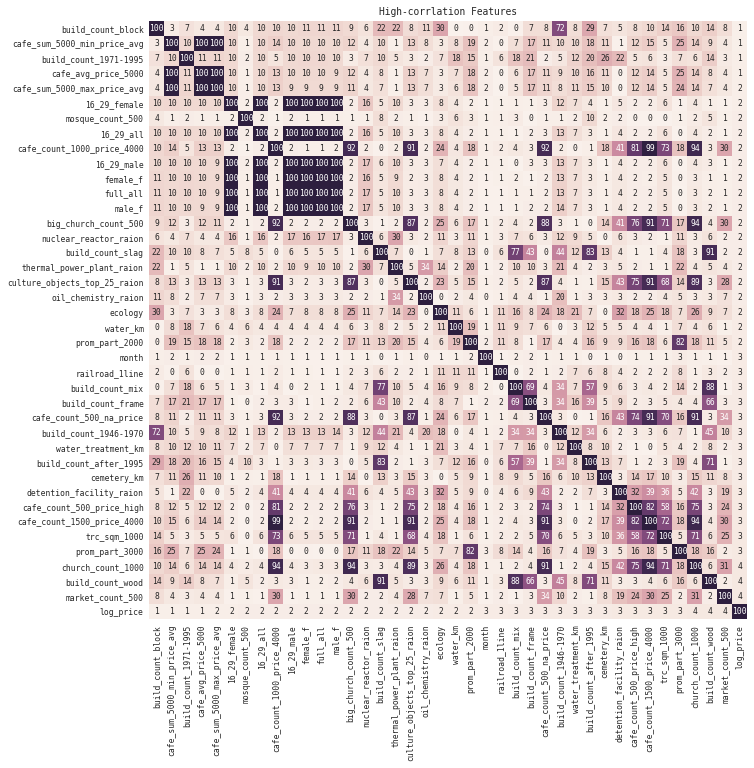

In [15]:
corr_target_f2 = corr_target_f
corr_target_f2.append('log_price')
high_corr = train_set[corr_target_f2].corr(method='pearson', min_periods=1000)
high_corr = np.abs(high_corr)*100
f, ax = plt.subplots(figsize=(11, 11))
sns.heatmap(high_corr, cbar=False, annot=True, square=True, fmt='.0f', 
            annot_kws={'size': 8})
plt.title('High-corrlation Features')
plt.show()

* delete duplicated features

In [16]:
remove_list = ['cafe_sum_5000_max_price_avg','16_29_male', 'female_f','full_all', 'male_f']
corr_target_f = [x for x in corr_target_f if x not in remove_list]

## Feature selection by xgb

In [17]:
train_y = train_set.log_price.values
train_X = train_set.drop(["id", "timestamp", "price_doc", "log_price"], axis=1)
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
remain_num = 99

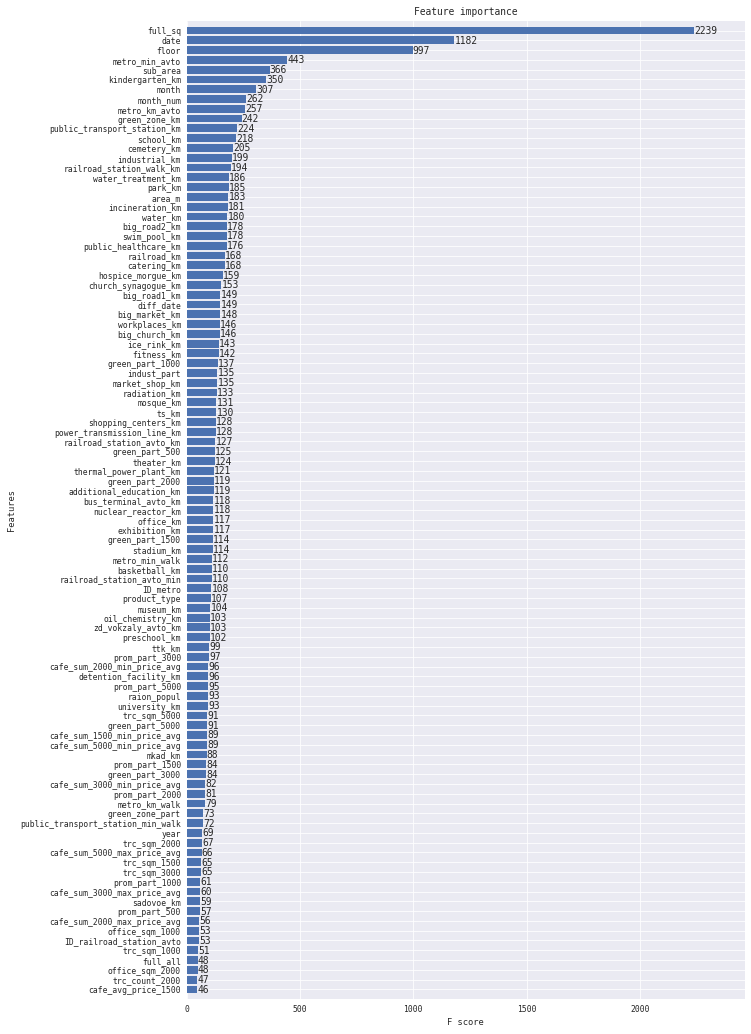

In [18]:
fig, ax = plt.subplots(figsize=(10,18))
xgb.plot_importance(model, max_num_features=remain_num, height=0.8, ax=ax)
plt.show()

* Even there is no obvious charateristics on time, derived columns`month` and `date` still have relatively high importance, that's interesting.

In [19]:
importance = model.get_score(importance_type='weight')
tuples = sorted([(k, importance[k]) for k in importance], key=lambda x: x[1], reverse=True)[:remain_num]
xgb_imp_f = [x[0] for x in tuples]

## Summary above

In [20]:
total_f = list(set(xgb_imp_f) | set(corr_target_f))
common_f = list(set(xgb_imp_f) & set(corr_target_f))
xgb_top_f = xgb_imp_f[:10]
corr_top_f = corr_target_f[:10]
print('there are {} features chosen in total'.format(len(total_f)))
print('there are {} features chosen in common'.format(len(common_f)))

there are 126 features chosen in total
there are 8 features chosen in common


## Simple test by total chosen features

### normalize and impute missing values

In [21]:
train_col = total_f
if 'log_price' not in train_col:
    train_col.append('log_price')
test_col = [x for x in train_col if x != 'log_price']
missing_imputer = preprocessing.Imputer(missing_values='NaN', strategy='most_frequent', axis=0, verbose=0, copy=True)
missing_imputer.fit(train_set[test_col])
train_data = pd.DataFrame(missing_imputer.transform(train_set[test_col]),columns = test_col)
train_data = pd.DataFrame(preprocessing.normalize(train_data, norm='l2', axis=0, 
                                                  copy=True, return_norm=False),columns = test_col)
train_data['log_price'] = train_set['log_price']

In [22]:
kf = model_selection.KFold(3,shuffle =True)
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
def cv_xgb(val_train_X,val_train_Y,val_val_X,val_val_Y):
    dtrain = xgb.DMatrix(val_train_X, val_train_Y, feature_names=val_train_X.columns)
    dval = xgb.DMatrix(val_val_X, val_val_Y, feature_names=val_val_X.columns)
    partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                           early_stopping_rounds=50, verbose_eval=20)
    num_boost_round = partial_model.best_iteration
    return(num_boost_round,partial_model.best_score)
for val_train, val_val in kf.split(train_data):
    val_train_X = train_data.ix[val_train].drop('log_price',axis=1)
    val_train_Y = train_data.ix[val_train].log_price
    val_val_X = train_data.ix[val_val].drop('log_price',axis=1)
    val_val_Y = train_data.ix[val_val].log_price
    print("%s %s %s %s" % (val_train_X.shape, val_train_Y.shape, val_train.shape, val_val.shape))
    print(cv_xgb(val_train_X,val_train_Y,val_val_X,val_val_Y))

(20314, 125) (20314,) (20314,) (10157,)
[0]	val-rmse:14.3677
Will train until val-rmse hasn't improved in 50 rounds.
[20]	val-rmse:5.17476
[40]	val-rmse:1.9109
[60]	val-rmse:0.815211
[80]	val-rmse:0.525125
[100]	val-rmse:0.472122
[120]	val-rmse:0.46401
[140]	val-rmse:0.46204
[160]	val-rmse:0.461587
[180]	val-rmse:0.461387
[200]	val-rmse:0.4613
[220]	val-rmse:0.461239
[240]	val-rmse:0.461323
Stopping. Best iteration:
[208]	val-rmse:0.461187

(208, 0.461187)
(20314, 125) (20314,) (20314,) (10157,)
[0]	val-rmse:14.3686
Will train until val-rmse hasn't improved in 50 rounds.
[20]	val-rmse:5.17514
[40]	val-rmse:1.91226
[60]	val-rmse:0.817958
[80]	val-rmse:0.529211
[100]	val-rmse:0.477457
[120]	val-rmse:0.469166
[140]	val-rmse:0.467282
[160]	val-rmse:0.466457
[180]	val-rmse:0.46606
[200]	val-rmse:0.465661
[220]	val-rmse:0.465585
[240]	val-rmse:0.465564
[260]	val-rmse:0.465728
[280]	val-rmse:0.465683
Stopping. Best iteration:
[232]	val-rmse:0.465491

(232, 0.465491)
(20314, 125) (20314,) (203

* Actually, it's not as good as what I expected, but not bad, we can play around a lot, to get better result.

### let's look at the top xgb_chosen features

In [23]:
for f in xgb_top_f:
    print(f)

full_sq
date
floor
metro_min_avto
sub_area
kindergarten_km
month
month_num
metro_km_avto
green_zone_km


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


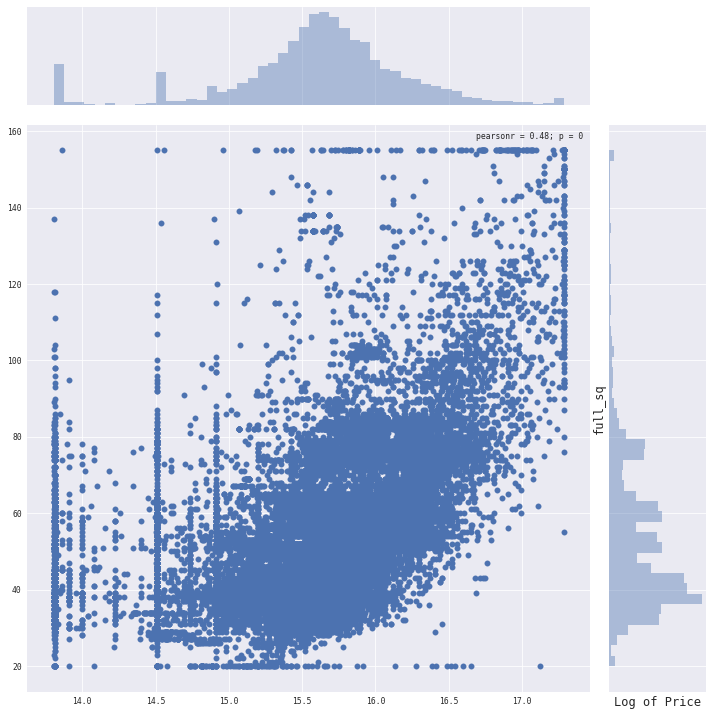

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


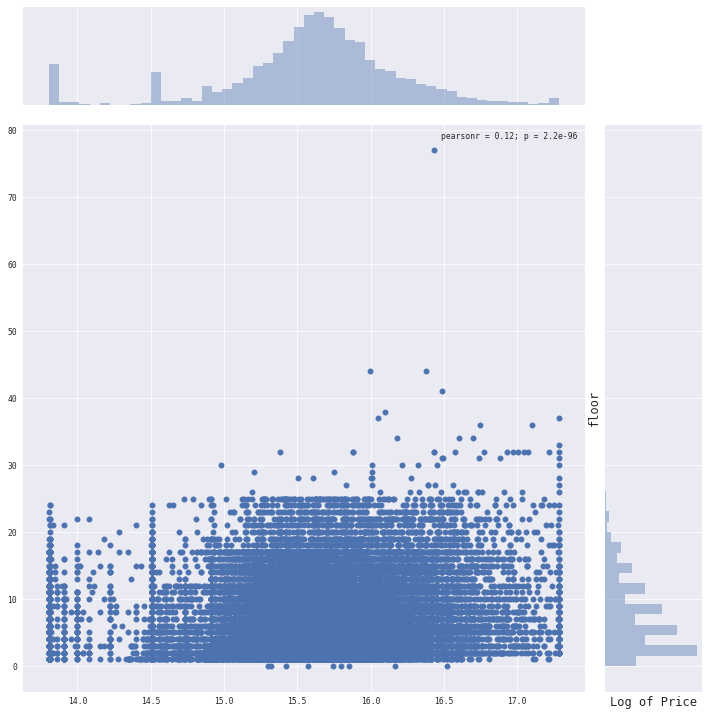

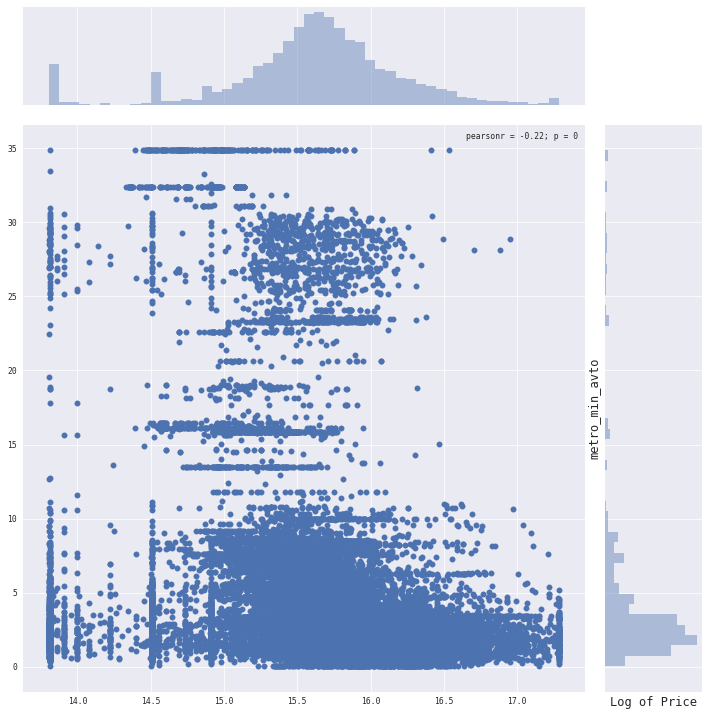

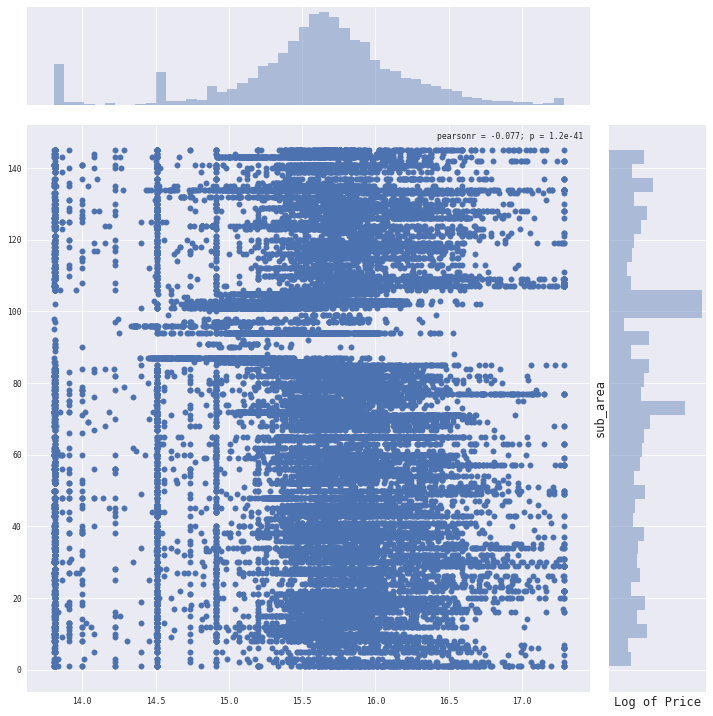

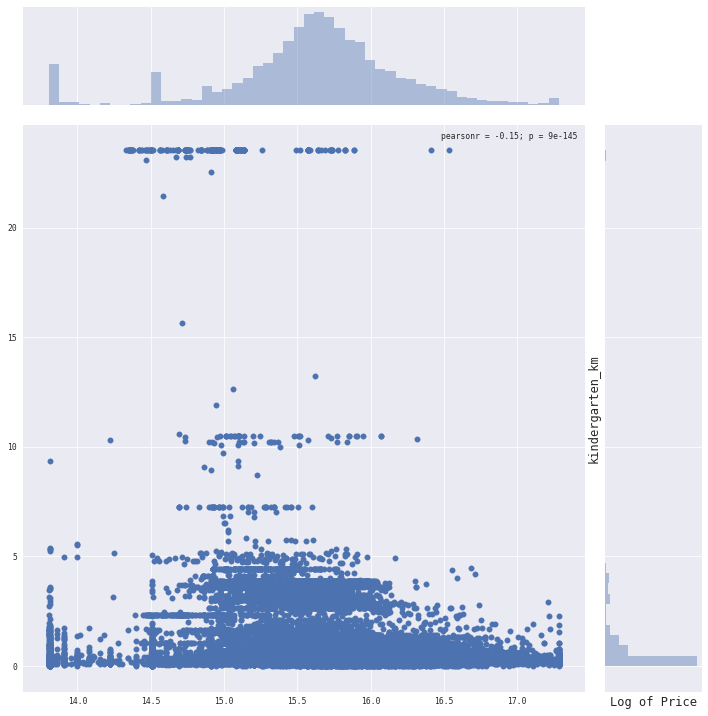

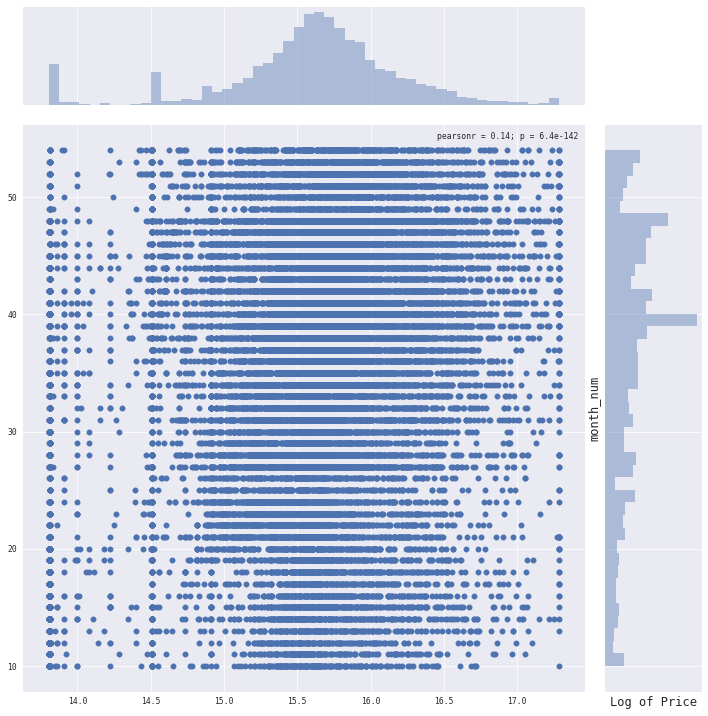

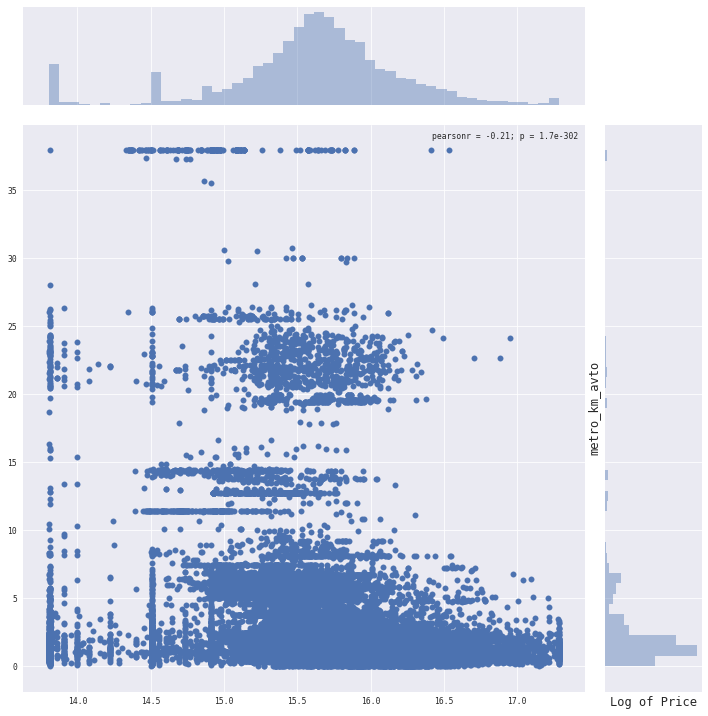

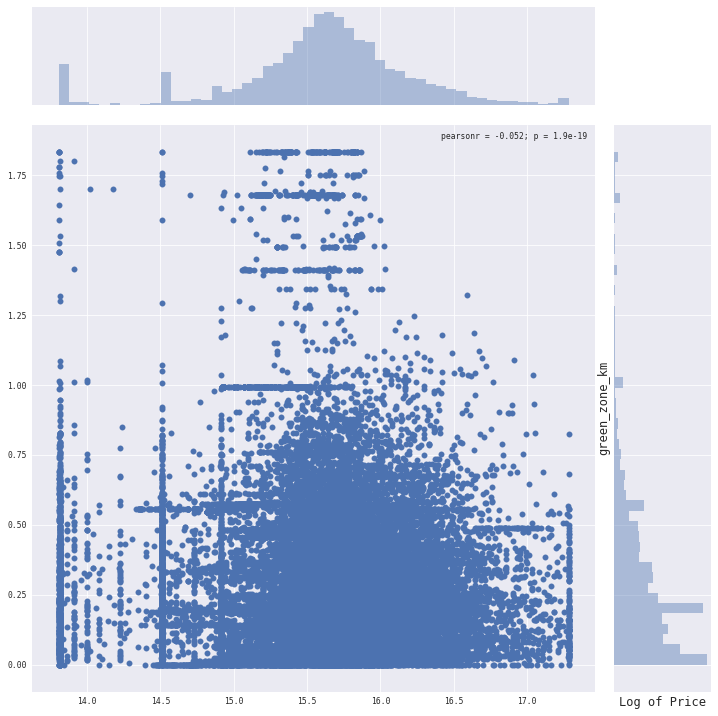

In [24]:
ulimit = np.percentile(train_set.log_price.values, 99.5)
llimit = np.percentile(train_set.log_price.values, 0.5)
train_set['log_price'].loc[train_set['log_price']>ulimit] = ulimit
train_set['log_price'].loc[train_set['log_price']<llimit] = llimit
for f in [x for x in xgb_top_f if x not in ['date', 'month']]:
    ulimit = np.percentile(train_set[f].values, 99.5)
    llimit = np.percentile(train_set[f].values, 0.5)
    train_set[f].loc[train_set[f]>ulimit] = ulimit
    train_set[f].loc[train_set[f]<llimit] = llimit
    plt.figure(figsize=(12,12))
    sns.jointplot(y=train_set[f].values, x=train_set.log_price.values, size=10)
    plt.xlabel('Log of Price', fontsize=12)
    plt.ylabel(f, fontsize=12)
    plt.show()

* Some plots are very interesting! we may get some good predictors after some transformation.

### All data preparation process on test set

In [25]:
test_df = pd.read_csv('../input/test.csv')
test_id = test_df['id']
# derive columns about time
test_df['date'] = test_df['timestamp'].apply(trans_date)
test_df['year'] = test_df.date.apply(lambda x: x.year)
test_df['month_num'] = test_df.date.apply(lambda x: x.month + 12*(x.year-2011))
test_df['month'] = test_df.date.apply(lambda x: x.month)
test_df['diff_date'] = test_df['date'].apply(lambda x: (x - start_date).days)
# drop columns with too much NAs
test_set = test_df.drop(delete_col, axis=1)
# transform types
for f in test_set.columns:
    if test_set[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(test_set[f].values)) 
        test_set[f] = lbl.transform(list(test_set[f].values))
# impute missing values and normalize
test_data = pd.DataFrame(missing_imputer.transform(test_set[test_col]),columns = test_col)
test_data = pd.DataFrame(preprocessing.normalize(test_data, norm='l2', axis=0, 
                                                  copy=True, return_norm=False),columns = test_col)


Dtest = xgb.DMatrix(test_data, feature_names=test_col)

more is coming...